# State Farm Distracted Driver Detection
This notebook contains code for State Farm Distracted Driver Detection dataset chanllenge. Kaggle link: https://www.kaggle.com/c/state-farm-distracted-driver-detection

## Importing packages
Install and import necessary libraries

In [1]:
!pip install tqdm

    100% |################################| 81kB 2.3MB/s ta 0:00:01
You are using pip version 9.0.3, however version 21.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import os
import shutil
import glob

import tqdm
import pandas as pd
import cv2
import caffe
import lmdb
import numpy as np
from sklearn.model_selection import train_test_split
from caffe.proto import caffe_pb2
from matplotlib import pyplot as plt

%matplotlib inline

## Preprocessing data
For large dataset we usually split the dataset into 3 subsets: training, validation and testing. We already have a individual test set for final evaluation. So we still need to split the original training set into a training and a validation set for parameters tuning.

As you know the dataset is already seperated into each class: one directory for images with label c0, another directory for images with label c1, etc. For loading the dataset thus we don't need the .csv file provided, we can go to the directories one by one and load the images, and for each image we record the parent directory name (c0, c1, ...) as the label for that image.

In [3]:
def prepare_data(data_dir, split=0.2):
    """Load raw data and split it into training and validation subset.
    
    Args
    :data_dir: Data root directory.
    
    Returns
    :X_train: A list of training image paths.
    :y_train: A list of training labels.
    :X_val: A list of validation image paths.
    :y_val: A list of validation labels.
    """
    imgs_list = []
    labels = []

    # List all image subdirectories and sort by class name
    img_dirs = sorted(glob.glob(os.path.join(data_dir, '*')), key = lambda k: k.split("/")[-1])
    for img_dir in img_dirs:
        # Read all the images in this class
        # Image subdirectory name as label
        for img_path in glob.glob(os.path.join(img_dir,'*.jpg')):
            imgs_list.append(img_path)
            labels.append(int(img_dir.split("/")[-1].replace('c', '')))
    
    # Split into training and validation subset
    X_train, X_test, y_train, y_test = train_test_split(imgs_list, labels, test_size = 0.2)
    
    return X_train, X_test, y_train, y_test

    #return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

## Get data
Here we use the function we just defined above to load data.

In [4]:
path_train_images = 'imgs/train'
path_test_images = 'imgs/test'

X_train, X_test, y_train, y_test = prepare_data(path_train_images)

print('Size of X_train: {}, size of y_train: {}'.format(len(X_train), len(y_train)))
print('Size of X_test: {}, size of y_test: {}'.format(len(X_test), len(y_test)))

Size of X_train: 11245, size of y_train: 11245
Size of X_test: 2812, size of y_test: 2812


## Data sanity check

Classes:
- c0: safe driving
- c1: texting - right
- c2: talking on the phone - right
- c3: texting - left
- c4: talking on the phone - left
- c5: operating the radio

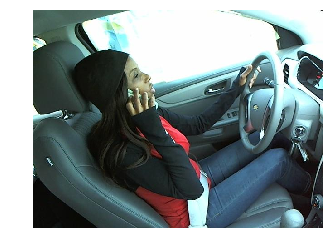

Class: 2


In [5]:
# Load an image
img = cv2.imread(X_train[65])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')
plt.show()

# Check label
print('Class: {}'.format(y_train[65]))

## Caffe Overview
Caffe is a deep learning framework developed by the Berkeley Vision and Learning Center (BVLC). It is written in C++ and has Python and Matlab interfaces.

There are 4 steps in training a CNN using Caffe:

- Step 1 - Data preparation: In this step, we get the images and store them in a format that can be used by Caffe. Here we will write a Python script that will handle image storage.

- Step 2 - Model definition: In this step, we choose a CNN architecture and we define its parameters in a configuration file with extension .prototxt.

- Step 3 - Solver definition: The solver is responsible for model optimization. We define the solver parameters in a configuration file with extension .prototxt.

- Step 4 - Model training: We train the model by executing caffe command from the terminal. After training the model, we will get the trained model in a file with extension .caffemodel.

After the training phase, we will use the .caffemodel trained model to make predictions of new unseen data.

## Data preparation
Here we prepare the raw dataset as LMDB database, which is standard Caffe data format. We need some piece of Python code.

In [5]:
import lmdb
import caffe
from caffe.proto import caffe_pb2


def transform_img(img, img_width=227, img_height=227):
    """Resize image.
    
    Args
    :img: numpy array image.
    :img_width: Target image width.
    :img_height: Target image height.
    
    Returns
      resized image.
    """
    img = cv2.resize(img, (img_width, img_height), interpolation=cv2.INTER_CUBIC)

    return img


def make_datum(img, label):
    """
    Convert original numpy array image to datum
    Args
    :img: numpy.ndarray (BGR instead of RGB)
    :label: int
    """
    return caffe_pb2.Datum(
        channels=3,
        width=227,
        height=227,
        label=label,
        data=np.rollaxis(img, 2).tostring())


def make_lmdb(lmdb_path, x_data, y_data):
    """Create LMDB database from the given raw images and labels.
    
    Args
    :lmdb_path: LMDB output path.
    :x_data: A list of image paths.
    :y_data: A list of labels.
    """
    in_db = lmdb.open(lmdb_path, map_size=int(1e12))
    with in_db.begin(write=True) as in_txn:
        for in_idx, img_path in tqdm.tqdm(enumerate(x_data)):
            img = cv2.imread(img_path)
            img = transform_img(img)
            datum = make_datum(img, y_data[in_idx])  # Making datum object
            in_txn.put('{:0>5d}'.format(in_idx).encode('utf-8'), datum.SerializeToString())
    in_db.close()

In [7]:
# Actually create training and validation database
train_lmdb = 'input/train_lmdb'
val_lmdb = 'input/validation_lmdb'

os.makedirs(train_lmdb, exist_ok=True)
os.makedirs(val_lmdb, exist_ok=True)
make_lmdb(train_lmdb, X_train, y_train)
make_lmdb(val_lmdb, X_test, y_test)

11245it [02:08, 87.81it/s] 
2812it [00:34, 82.12it/s]


### Links to articles that explain how to create a Neural network in Caffe

1. https://prateekvjoshi.com/2016/04/19/how-to-programmatically-create-a-deep-neural-network-in-python-caffe/
2. https://github.com/BVLC/caffe/wiki/Making-Prototxt-Nets-with-Python

## Create architecture
Caffe philosophy is expression, modularity and speed. For that we use text files to define networks, instead of code API like Keras. Coding is possible in Caffe too, but highly discoureged.

After deciding on the CNN architecture, we need to define its parameters in a .prototxt file. Here is the details of the defined network structure in my git repo.

### 1. Data Layer
Data enters Caffe through data layers: they lie at the bottom of nets. Data can come from efficient databases (LevelDB or LMDB), directly from memory, or, when efficiency is not critical, from files on disk in HDF5 or common image formats. Parameters we have in data layer:


### 2. Convolution layer
This layer recieves the data blob from last layer and produces conv1 blob. Convolution layers in neural networks generally convolve the input image with a set of learnable filters, each producing one feature map in the output image.


### 3. Pooling layer
We set the pool to max so it does max pooling operation on convolution outputs.

### 4. Dense layer
This layer is similar to previous layers too. Dense layers are knows as InnerProduct layers in Caffe.


### 5. ReLU layer
Since ReLU is element-wise we can do the operation once and not waste memory. This can be done with defining one name for top and bottom layers. Note that we can not have same names for blob of other layers and this is pecuilar for this layer.


### 6. Loss
We define loss function here.

## Caffe Solver
The solver is responsible for model optimization. We define the solver's parameters in a .prototxt file. 

This solver computes the accuracy of the model using the validation set every 100 iterations. The optimization process will run for a maximum of 300 iterations and will take a snapshot of the trained model every 50 iterations.

base_lr, lr_policy, gamma, momentum and weight_decay are hyperparameters that we need to tune to get a good convergence of the model.

I chose lr_policy: "step" with stepsize: 200, base_lr: 0.001 and gamma: 0.1. In this configuration, we will start with a learning rate of 0.001, and we will drop the learning rate by a factor of ten every 200 iterations.

There are different strategies for the optimization process. For a detailed explanation, you can read Caffe's solver documentation.
```
net: "caffe-cnn/cnn/cnn.prototxt"
test_iter: 88
test_interval: 100
base_lr: 0.001
lr_policy: "step"
gamma: 0.1
stepsize: 200
display: 50
max_iter: 300
momentum: 0.9
weight_decay: 0.0005
snapshot: 50
snapshot_prefix: "./snapshot/cnn"
solver_mode: CPU

```

## Training


In [8]:
#!mkdir -p ./snapshot/cnn

!caffe train --solver "caffe-cnn/cnn/cnn_solver.prototxt"

I0215 15:04:42.799659   119 upgrade_proto.cpp:1113] snapshot_prefix was a directory and is replaced to ./snapshot/cnn/cnn_solver
I0215 15:04:42.801637   119 caffe.cpp:197] Use CPU.
I0215 15:04:42.802870   119 solver.cpp:45] Initializing solver from parameters: 
test_iter: 88
test_interval: 100
base_lr: 0.001
display: 50
max_iter: 300
lr_policy: "step"
gamma: 0.1
momentum: 0.9
weight_decay: 0.0005
stepsize: 200
snapshot: 50
snapshot_prefix: "./snapshot/cnn/cnn_solver"
solver_mode: CPU
net: "caffe-cnn/cnn/cnn.prototxt"
train_state {
  level: 0
  stage: ""
}
I0215 15:04:42.806483   119 solver.cpp:102] Creating training net from net file: caffe-cnn/cnn/cnn.prototxt
I0215 15:04:42.809976   119 net.cpp:294] The NetState phase (0) differed from the phase (1) specified by a rule in layer data
I0215 15:04:42.810076   119 net.cpp:294] The NetState phase (0) differed from the phase (1) specified by a rule in layer accuracy
I0215 15:04:42.810252   119 net.cpp:51] Initializing net from parameters: 

I0215 15:04:45.220129   119 net.cpp:122] Setting up fc5
I0215 15:04:45.220191   119 net.cpp:129] Top shape: 32 512 (16384)
I0215 15:04:45.220211   119 net.cpp:137] Memory required for data: 886238720
I0215 15:04:45.220240   119 layer_factory.hpp:77] Creating layer relu5
I0215 15:04:45.220258   119 net.cpp:84] Creating Layer relu5
I0215 15:04:45.220278   119 net.cpp:406] relu5 <- fc5
I0215 15:04:45.220320   119 net.cpp:367] relu5 -> fc5 (in-place)
I0215 15:04:45.220345   119 net.cpp:122] Setting up relu5
I0215 15:04:45.220357   119 net.cpp:129] Top shape: 32 512 (16384)
I0215 15:04:45.220371   119 net.cpp:137] Memory required for data: 886304256
I0215 15:04:45.220422   119 layer_factory.hpp:77] Creating layer drop5
I0215 15:04:45.220495   119 net.cpp:84] Creating Layer drop5
I0215 15:04:45.220506   119 net.cpp:406] drop5 <- fc5
I0215 15:04:45.220528   119 net.cpp:367] drop5 -> fc5 (in-place)
I0215 15:04:45.220562   119 net.cpp:122] Setting up drop5
I0215 15:04:45.220578   119 net.cpp:12

I0215 15:04:45.728911   119 net.cpp:122] Setting up fc5
I0215 15:04:45.728973   119 net.cpp:129] Top shape: 32 512 (16384)
I0215 15:04:45.728993   119 net.cpp:137] Memory required for data: 886238976
I0215 15:04:45.729018   119 layer_factory.hpp:77] Creating layer relu5
I0215 15:04:45.729041   119 net.cpp:84] Creating Layer relu5
I0215 15:04:45.729063   119 net.cpp:406] relu5 <- fc5
I0215 15:04:45.729104   119 net.cpp:367] relu5 -> fc5 (in-place)
I0215 15:04:45.729125   119 net.cpp:122] Setting up relu5
I0215 15:04:45.729137   119 net.cpp:129] Top shape: 32 512 (16384)
I0215 15:04:45.729156   119 net.cpp:137] Memory required for data: 886304512
I0215 15:04:45.729174   119 layer_factory.hpp:77] Creating layer drop5
I0215 15:04:45.729194   119 net.cpp:84] Creating Layer drop5
I0215 15:04:45.729208   119 net.cpp:406] drop5 <- fc5
I0215 15:04:45.729228   119 net.cpp:367] drop5 -> fc5 (in-place)
I0215 15:04:45.729240   119 net.cpp:122] Setting up drop5
I0215 15:04:45.729259   119 net.cpp:12

I0215 15:27:08.725795   119 sgd_solver.cpp:280] Snapshotting solver state to binary proto file ./snapshot/cnn/cnn_solver_iter_200.solverstate
I0215 15:27:11.326156   119 solver.cpp:351] Iteration 200, Testing net (#0)
I0215 15:29:57.317215   128 data_layer.cpp:73] Restarting data prefetching from start.
I0215 15:30:05.129848   119 solver.cpp:418]     Test net output #0: accuracy = 0.159446
I0215 15:30:05.130187   119 solver.cpp:418]     Test net output #1: loss = 1.81574 (* 1 = 1.81574 loss)
I0215 15:30:10.311048   119 solver.cpp:239] Iteration 200 (0.113274 iter/s, 441.407s/50 iters), loss = 1.77028
I0215 15:30:10.311182   119 solver.cpp:258]     Train net output #0: loss = 1.77028 (* 1 = 1.77028 loss)
I0215 15:30:10.311214   119 sgd_solver.cpp:112] Iteration 200, lr = 0.0001
I0215 15:34:38.156522   119 solver.cpp:468] Snapshotting to binary proto file ./snapshot/cnn/cnn_solver_iter_250.caffemodel
I0215 15:34:42.490927   119 sgd_solver.cpp:280] Snapshotting solver state to binary prot

During the training process, we need to monitor the loss and the model accuracy. We can stop the process at anytime by pressing stop button. Caffe will take a snapshot of the trained model every 50 iterations, and store them under `./snapshot/cnn` folder.

The snapshots have .caffemodel extension. For example, 50 iterations snapshot will be called: `cnn_iter_50.caffemodel`

## Prediction
We will use the trained model to make prediction on test data.

In [9]:
net = caffe.Net('caffe-cnn/cnn/cnn.prototxt',
                './snapshot/cnn/cnn_solver_iter_300.caffemodel', caffe.TEST)

In [10]:
out = net.forward()

In [11]:
acc, loss = out['accuracy'].copy(), out['loss'].copy()
print('Accuracy: {:.2f}% Loss: {:.4f}'.format(acc*100, loss))

Accuracy: 9.38% Loss: 1.7977


Class:  1


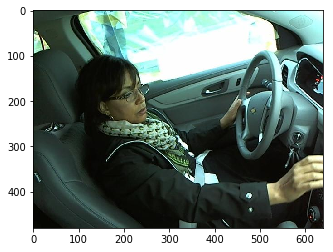

In [12]:
net = caffe.Classifier('caffe-cnn/cnn/cnn_deploy.prototxt',
                       './snapshot/cnn/cnn_solver_iter_300.caffemodel',
                       image_dims=(227, 227),
                       raw_scale=255)

img_path = './imgs/test/img_1.jpg'

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

score = net.predict([caffe.io.load_image(img_path)])
print('Class: ', score.argmax())

## Transfer Learning
Caffe comes with a repository that is used by researchers and machine learning practitioners to share their trained models. This library is called Model Zoo.

Using this command we download the CaffeNet network structure, trained on ImageNet dataset.

In [ ]:
!wget http://dl.caffe.berkeleyvision.org/bvlc_reference_caffenet.caffemodel

In [ ]:
#!mkdir -p ./snapshot/caffenet

In [6]:
!caffe train --solver="caffe-cnn/caffenet/solver.prototxt" --weights "bvlc_reference_caffenet.caffemodel"

I0217 06:26:58.353507    52 upgrade_proto.cpp:1113] snapshot_prefix was a directory and is replaced to ./snapshot/caffenet/solver
I0217 06:26:58.355533    52 caffe.cpp:197] Use CPU.
I0217 06:26:58.357429    52 solver.cpp:45] Initializing solver from parameters: 
test_iter: 88
test_interval: 100
base_lr: 0.001
display: 50
max_iter: 200
lr_policy: "step"
gamma: 0.1
momentum: 0.9
weight_decay: 0.0005
stepsize: 100
snapshot: 50
snapshot_prefix: "./snapshot/caffenet/solver"
solver_mode: CPU
net: "caffe-cnn/caffenet/net.prototxt"
train_state {
  level: 0
  stage: ""
}
weights: "bvlc_reference_caffenet.caffemodel"
I0217 06:26:58.361275    52 solver.cpp:102] Creating training net from net file: caffe-cnn/caffenet/net.prototxt
I0217 06:26:58.366159    52 net.cpp:294] The NetState phase (0) differed from the phase (1) specified by a rule in layer data
I0217 06:26:58.366222    52 net.cpp:294] The NetState phase (0) differed from the phase (1) specified by a rule in layer accuracy
I0217 06:26:58.3

I0217 06:26:58.435158    52 net.cpp:122] Setting up conv4
I0217 06:26:58.435217    52 net.cpp:129] Top shape: 32 384 13 13 (2076672)
I0217 06:26:58.435231    52 net.cpp:137] Memory required for data: 195816960
I0217 06:26:58.435264    52 layer_factory.hpp:77] Creating layer relu4
I0217 06:26:58.435307    52 net.cpp:84] Creating Layer relu4
I0217 06:26:58.435346    52 net.cpp:406] relu4 <- conv4
I0217 06:26:58.435395    52 net.cpp:367] relu4 -> conv4 (in-place)
I0217 06:26:58.435461    52 net.cpp:122] Setting up relu4
I0217 06:26:58.435513    52 net.cpp:129] Top shape: 32 384 13 13 (2076672)
I0217 06:26:58.435526    52 net.cpp:137] Memory required for data: 204123648
I0217 06:26:58.435544    52 layer_factory.hpp:77] Creating layer conv5
I0217 06:26:58.435567    52 net.cpp:84] Creating Layer conv5
I0217 06:26:58.435607    52 net.cpp:406] conv5 <- conv4
I0217 06:26:58.435659    52 net.cpp:380] conv5 -> conv5
I0217 06:26:58.447031    52 net.cpp:122] Setting up conv5
I0217 06:26:58.447106  

I0217 06:27:02.491988    52 upgrade_proto.cpp:63] Successfully upgraded file specified using deprecated V1LayerParameter
I0217 06:27:02.551352    52 net.cpp:744] Ignoring source layer fc8
I0217 06:27:02.609025    52 solver.cpp:190] Creating test net (#0) specified by net file: caffe-cnn/caffenet/net.prototxt
I0217 06:27:02.609138    52 net.cpp:294] The NetState phase (1) differed from the phase (0) specified by a rule in layer data
I0217 06:27:02.609324    52 net.cpp:51] Initializing net from parameters: 
name: "CaffeNet"
state {
  phase: TEST
}
layer {
  name: "data"
  type: "Data"
  top: "data"
  top: "label"
  include {
    phase: TEST
  }
  transform_param {
    mirror: true
    crop_size: 227
  }
  data_param {
    source: "./input/validation_lmdb"
    batch_size: 32
    backend: LMDB
  }
}
layer {
  name: "conv1"
  type: "Convolution"
  bottom: "data"
  top: "conv1"
  param {
    lr_mult: 1
    decay_mult: 1
  }
  param {
    lr_mult: 2
    decay_mult: 0
  }
  convolution_param {

I0217 06:27:02.953408    52 net.cpp:122] Setting up fc6
I0217 06:27:02.953488    52 net.cpp:129] Top shape: 32 4096 (131072)
I0217 06:27:02.953516    52 net.cpp:137] Memory required for data: 216903424
I0217 06:27:02.953544    52 layer_factory.hpp:77] Creating layer relu6
I0217 06:27:02.953575    52 net.cpp:84] Creating Layer relu6
I0217 06:27:02.953647    52 net.cpp:406] relu6 <- fc6
I0217 06:27:02.953676    52 net.cpp:367] relu6 -> fc6 (in-place)
I0217 06:27:02.953707    52 net.cpp:122] Setting up relu6
I0217 06:27:02.953735    52 net.cpp:129] Top shape: 32 4096 (131072)
I0217 06:27:02.953761    52 net.cpp:137] Memory required for data: 217427712
I0217 06:27:02.953788    52 layer_factory.hpp:77] Creating layer drop6
I0217 06:27:02.953816    52 net.cpp:84] Creating Layer drop6
I0217 06:27:02.953850    52 net.cpp:406] drop6 <- fc6
I0217 06:27:02.953872    52 net.cpp:367] drop6 -> fc6 (in-place)
I0217 06:27:02.953900    52 net.cpp:122] Setting up drop6
I0217 06:27:02.953928    52 net.cp

I0217 06:27:05.073261    52 solver.cpp:351] Iteration 0, Testing net (#0)
I0217 06:29:13.980361    61 data_layer.cpp:73] Restarting data prefetching from start.
I0217 06:29:20.275686    52 solver.cpp:418]     Test net output #0: accuracy = 0.152699
I0217 06:29:20.275766    52 solver.cpp:418]     Test net output #1: loss = 1.93992 (* 1 = 1.93992 loss)
I0217 06:29:24.662663    52 solver.cpp:239] Iteration 0 (-1.4013e-45 iter/s, 139.677s/50 iters), loss = 2.3745
I0217 06:29:24.662822    52 solver.cpp:258]     Train net output #0: loss = 2.3745 (* 1 = 2.3745 loss)
I0217 06:29:24.662878    52 sgd_solver.cpp:112] Iteration 0, lr = 0.001
I0217 06:32:57.675514    52 solver.cpp:468] Snapshotting to binary proto file ./snapshot/caffenet/solver_iter_50.caffemodel
I0217 06:33:09.778199    52 sgd_solver.cpp:280] Snapshotting solver state to binary proto file ./snapshot/caffenet/solver_iter_50.solverstate
I0217 06:33:24.101246    52 solver.cpp:239] Iteration 50 (0.208822 iter/s, 239.438s/50 iters), 

Test this transfer learning model

In [7]:
import caffe

net = caffe.Net('caffe-cnn/caffenet/net.prototxt',
                './snapshot/caffenet/solver_iter_200.caffemodel', caffe.TEST)

In [8]:
out = net.forward()

In [9]:
acc, loss = out['accuracy'].copy(), out['loss'].copy()
print('Accuracy: {:.2f}% Loss: {:.4f}'.format(acc*100, loss))

Accuracy: 96.88% Loss: 0.1891


Class:  2


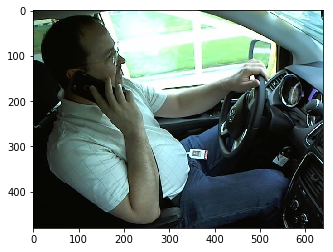

In [11]:
net = caffe.Classifier('caffe-cnn/caffenet/net_deploy.prototxt',
                       './snapshot/caffenet/solver_iter_200.caffemodel',
                       image_dims=(227, 227),
                       raw_scale=255)
img_path = './imgs/test/img_87.jpg'

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

score = net.predict([caffe.io.load_image(img_path)])
print('Class: ', score.argmax())